Fine-tuning BERT to solve the GLUE task - CoLA (Corpus of Linguistic Acceptability) for determining whether a sentence is grammatically acceptable.

Trained using Google Colab

Install dependencies

In [1]:
!pip install transformers

In [2]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c7a7b339633ecf1f97d4ab907145a159a38b7aef2a463e8c642d12333c43a33b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


Imports

In [4]:
import torch
import wget
import os
import pandas as pd
import random
import numpy as np
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn.metrics as smetrics

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler

In [5]:
seed = 2020

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Connecting to the GPU

In [6]:
# Check GPU availablity and connect if found.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Connecting to GPU - ', torch.cuda.get_device_name(0))
else:
    print('No GPU found. Using the CPU instead.')
    device = torch.device("cpu")

Connecting to GPU -  Tesla T4


Loading the dataset

In [7]:
print('Downloading dataset...')

# URL to dataset
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

In [8]:
# Download the file
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [9]:
# Unzip the dataset
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


Extract data

In [10]:
# Load the dataset using pandas
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['source', 'label', 'label_notes', 'sentence'])

# Print number of sentences
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,source,label,label_notes,sentence
2161,l-93,1,NaN,Carla hit Bill's back.
6718,m_02,1,NaN,Who thought up the proposal that the committee...
5934,c_13,1,NaN,Phillip gave the soldier the medal.
3293,l-93,1,NaN,The beer bubbled.
95,gj04,0,*,The ball wriggled itself loose.
7916,ad03,1,NaN,It rained
2504,l-93,1,NaN,Amanda burned the stove black.
2011,rhl07,1,NaN,Fred kicked the ball over the fence.
5393,b_73,1,NaN,She writes more clearly than she speaks.
1522,r-67,0,*,That the sun is out was obvious.


In [11]:
# Get lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.astype(int).values

Some helper modules

In [12]:
def preprocess_text(sentences, tokenizer, seq_length = 64):
  '''
  Returns input_ids and attention_masks from the input data for the BERT model

  Args:
  sentences: text data to be processed
  tokenizer: tokenizer of the selected BERT model
  seq_length: integer defining the sequence legnth of BERT inputs
  (default = 64, due to quadratic computation cost of attention)

  Returns:
  input_ids: input_ids of the sentences using selected BERT tokenizer
  attention_masks: attention masks for the sentences using selected BERT tokenizer
  '''

  input_ids = []
  attention_masks = []

  for s in sentences:
    # Encode sentence
    # 1. Tokenize the sentence
    # 2. Append special tokens '[CLS]' and '[SEP]'.
    # 3. Map tokens to IDs
    # 4. Pad or truncate sentence to 'seq_length'
    # 5. Create attention masks for '[PAD]' tokens
    # 6. Return pytorch tensors
    encoded_dict = tokenizer.encode_plus(s,
                                         add_special_tokens=True,
                                         max_length = seq_length,
                                         pad_to_max_length = True,
                                         return_attention_mask = True,
                                         return_tensors='pt'
                                         )

    # Add input ids to input_ids
    input_ids.append(encoded_dict['input_ids'])

    # Add attention masks to attention_masks
    attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists to tensors
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  return input_ids, attention_masks

In [13]:
def split_dataset(input_ids, attention_masks, labels, batch_size):
  '''
  Creates a DataLoader for training and validation tasks

  Args:
  input_ids: input_ids of the sentences using selected BERT tokenizer
  attention_masks: attention masks for the sentences using selected BERT tokenizer
  labels: true labels of the data
  batch_size: number of examples in individual data batches

  Returns:
  train_loader: DataLoader iterable containing randomly sampled batches of training data having size `batch_size` in required format
  val_loader: DataLoader iterable containing randomly sampled batches of validation data having size `batch_size` in required format
  '''

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Split dataset into 90-10 train-validation sets using random samples
  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  # Create DataLoaders (save memory by not loading entire dataset)
  train_loader = DataLoader(train_dataset,
                            sampler = RandomSampler(train_dataset),
                            batch_size = batch_size
                            )

  val_loader = DataLoader(val_dataset,
                            sampler = RandomSampler(val_dataset),
                            batch_size = batch_size
                            )

  return train_loader, val_loader

In [14]:
def init_model(bert_model_name, num_labels):
  '''
  Initialize pre-trained BERT model

  Args:
  bert_model_name: String. Name of the BERT model to be used.
  num_labels: Number of classification labels

  Returns:
  model: Pre-trained BERT model with a linear layer on top for classification, loaded to device
  '''

  # We are using BertForSequentialClassification for this task.
  # It is a pre-trained BERT model with a single linear layer on top for classification.
  model = BertForSequenceClassification.from_pretrained(bert_model_name,
                                                        num_labels = num_labels,
                                                        output_attentions = False,
                                                        output_hidden_states = False,
                                                        )
  # Set model to run on GPU
  model.cuda()

  # Print model parameters
  model_params = list(model.named_parameters())
  print("The model parameters are : ")
  print("Embedding Layer: ")
  for p in model_params[0:5]:
    print("{:<60} {:>10}".format(p[0], str(tuple(p[1].size()))))

  print("Transformer Layers: ")
  for p in model_params[5:25]:
    print("{:<60} {:>10}".format(p[0], str(tuple(p[1].size()))))

  print("Output Layer: ")
  for p in model_params[-4:]:
    print("{:<60} {:>10}".format(p[0], str(tuple(p[1].size()))))

  return model


In [15]:
def init_optimizer(model, num_steps, lr = 2e-5, eps = 1e-8):
  '''
  Initialize AdamW optimizer and learning rate schedule for model training

  Args:
  model: BERT model to be fine tuned
  num_steps: total number of steps across all epochs
  lr: learning rate (default = 2e-5, selected from BERT paper)
  eps: term added to denominator for numerical stability of AdamW (default: 1e-8)

  Returns:
  optimizer: AdamW optimizer initialized with hyperparameters
  scheduler: Learning rate schedule for the optimizer
  '''

  # We are using AdamW optimizer with learning rate = 2e-5, eps = 1e-8 and number of steps = num_steps
  optimizer = AdamW(model.parameters(),
                    lr = lr,
                    eps = eps,
                    )

  # Set a learning rate schedule with warmup_steps = 0 and training_steps = num_steps
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps = 0,
                                              num_training_steps = num_steps
                                              )
  return optimizer, scheduler

In [16]:
def model_training_epoch(model, train_loader, optimizer, scheduler):
  '''
  Training of BERT model for current epoch

  Args:
  model: BERT model to be fine tuned
  train_loader: DataLoader iterable for training data
  optimizer: optimizer for tuning model parameters
  scheduler: Learning rate schedule for the optimizer

  Returns:
  model: Fine-tuned BERT model
  total_loss: Total training loss across all batches for current epoch
  '''

  # Variable for total_loss for this epoch
  total_loss = 0

  # Get start time for current epoch training
  train_time_start = time.time()

  # Set model to training mode
  model.train()

  # Go through the training data
  for step, batch in enumerate(train_loader):
    # Print step progress every 30 steps
    if step != 0 and step % 30 == 0:
      elapsed_time = int(round(time.time() - train_time_start))
      print('Batch {:>5,}  |  {:>5,}.    Elapsed time: {:}.'.format(step, len(train_loader), datetime.timedelta(seconds=elapsed_time)))

    # Unpack training data and copy to GPU
    train_input_ids = batch[0].to(device)
    train_attention_masks = batch[1].to(device)
    train_labels = batch[2].type(torch.LongTensor)
    train_labels = train_labels.to(device)

    # Clear gradients
    model.zero_grad()

    # Forward pass
    loss, logits = model(train_input_ids, attention_mask = train_attention_masks, labels = train_labels).to_tuple()

    # Accumulate total loss
    total_loss += loss.item()

    # Backpropogate loss to get gradients
    loss.backward()

    # Clip norm of gradients to 1.0 (to prevent exploding gradient)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Perform an optimization step to update weights
    optimizer.step()

    # Update learning rate using scheduler step
    scheduler.step()

  return model, total_loss

In [17]:
def model_eval_epoch(model, loader):
  '''
  Evaluation of BERT model for current epoch

  Args:
  model: BERT model to be evaluated
  loader: DataLoader iterable for evaluation data

  Returns:
  pred_labels: Predicted data labels
  true_labels: True data labels
  total_loss: Total evaluation loss across all batches for current epoch
  '''

  # Variable for total_loss for this epoch
  total_loss = 0

  # Variables to store predictions and corresoponding true labels
  pred_labels, true_labels = [], []

  # Set model to evaluation mode
  model.eval()

  # Go through the loader data
  for _, batch in enumerate(loader):
    # Unpack loader data and copy to GPU
    batch_input_ids = batch[0].to(device)
    batch_attention_masks = batch[1].to(device)
    batch_labels = batch[2].type(torch.LongTensor).to(device)

    # Evaluate model with no gradient calculation
    with torch.no_grad():
      # Forward pass
      loss, logits = model(batch_input_ids, attention_mask = batch_attention_masks, labels = batch_labels).to_tuple()

    # Accumulate total loss
    total_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    batch_labels = batch_labels.cpu().numpy()

    # Store predictions and labels
    pred_labels.append(logits)
    true_labels.append(batch_labels)

  return pred_labels, true_labels, total_loss

Selection of model, tokenizer and setting hyper parameters

In [18]:
bert_model_name = 'bert-base-uncased'

In [19]:
# Loading the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# Convert labels to tensors
labels = torch.Tensor(labels)

In [21]:
# Set training hyperparameters (values chosen as suggested by authors of BERT)
batch_size = 32
num_labels = 2
lr = 2e-5
eps = 1e-8
epochs = 2

Preprocess data, setup loader and load models

In [22]:
input_ids, attention_masks = preprocess_text(sentences, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
train_loader, val_loader = split_dataset(input_ids, attention_masks, labels, batch_size)

In [24]:
model = init_model(bert_model_name, num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model parameters are : 
Embedding Layer: 
bert.embeddings.word_embeddings.weight                       (30522, 768)
bert.embeddings.position_embeddings.weight                   (512, 768)
bert.embeddings.token_type_embeddings.weight                   (2, 768)
bert.embeddings.LayerNorm.weight                                 (768,)
bert.embeddings.LayerNorm.bias                                   (768,)
Transformer Layers: 
bert.encoder.layer.0.attention.self.query.weight             (768, 768)
bert.encoder.layer.0.attention.self.query.bias                   (768,)
bert.encoder.layer.0.attention.self.key.weight               (768, 768)
bert.encoder.layer.0.attention.self.key.bias                     (768,)
bert.encoder.layer.0.attention.self.value.weight             (768, 768)
bert.encoder.layer.0.attention.self.value.bias                   (768,)
bert.encoder.layer.0.attention.output.dense.weight           (768, 768)
bert.encoder.layer.0.attention.output.dense.bias                 (7

In [25]:
num_steps = len(train_loader) * epochs
optimizer, scheduler = init_optimizer(model, num_steps=num_steps, lr=lr, eps=eps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model training and validation

In [26]:
# Store some training stats
stats = []

overall_time_start = time.time()

for e in range(0, epochs):
  # Print current training epoch
  print("Epoch {} | {}".format(e+1, epochs))
  print("Training")

  # Get start time for training
  e_train_start = time.time()

  # Model training
  model, epoch_train_loss = model_training_epoch(model, train_loader, optimizer, scheduler)

  # Training time for this epoch
  training_time = time.time() - e_train_start

  # Average training loss across all batches
  avg_training_loss = epoch_train_loss/len(train_loader)

  print("  Average training loss: {0:.2f}".format(avg_training_loss))
  print("  Epoch training time: {:}".format(training_time))

  print("Validation")

  # Get start time for validaiton
  e_val_start = time.time()

  # Model validation
  _, _, epoch_val_loss = model_eval_epoch(model, val_loader)

  # Validation time for this epoch
  val_time = time.time() - e_val_start

  # Average validation loss across all batches
  avg_val_loss = epoch_val_loss/len(val_loader)

  print("  Average validation loss: {0:.2f}".format(avg_val_loss))
  print("  Epoch validation time: {:}".format(datetime.timedelta(seconds=int(round(val_time)))))

  # Store stats
  stats.append(
    {
      'Epoch': e + 1,
      'Training Time': training_time,
      'Training Loss': avg_training_loss,
      'Validation Time': val_time,
      'Validation Loss': avg_val_loss
    }
  )

print("")
print("Training complete!")

print("Total training time {:} (hh:mm:ss)".format(datetime.timedelta(seconds=int(round(time.time()-overall_time_start)))))

Epoch 1 | 2
Training
Batch    30  |    241.    Elapsed time: 0:00:12.
Batch    60  |    241.    Elapsed time: 0:00:21.
Batch    90  |    241.    Elapsed time: 0:00:31.
Batch   120  |    241.    Elapsed time: 0:00:40.
Batch   150  |    241.    Elapsed time: 0:00:50.
Batch   180  |    241.    Elapsed time: 0:01:00.
Batch   210  |    241.    Elapsed time: 0:01:09.
Batch   240  |    241.    Elapsed time: 0:01:19.
  Average training loss: 0.51
  Epoch training time: 78.82324838638306
Validation
  Average validation loss: 0.44
  Epoch validation time: 0:00:03
Epoch 2 | 2
Training
Batch    30  |    241.    Elapsed time: 0:00:09.
Batch    60  |    241.    Elapsed time: 0:00:19.
Batch    90  |    241.    Elapsed time: 0:00:28.
Batch   120  |    241.    Elapsed time: 0:00:38.
Batch   150  |    241.    Elapsed time: 0:00:48.
Batch   180  |    241.    Elapsed time: 0:00:57.
Batch   210  |    241.    Elapsed time: 0:01:07.
Batch   240  |    241.    Elapsed time: 0:01:16.
  Average training loss: 0.

Training stats

In [27]:
# Set precision to 2 places
pd.set_option('display.precision', 4)

# Create a DataFrame from our training statistics.
stats_df = pd.DataFrame(data=stats)

# Set 'Epoch' as row index
stats_df = stats_df.set_index('Epoch')

# Display the table.
stats_df

,Training Time,Training Loss,Validation Time,Validation Loss
Epoch,,,,
1,78.8232,0.5130,2.8519,0.4391
2,76.4893,0.3408,2.8801,0.4437


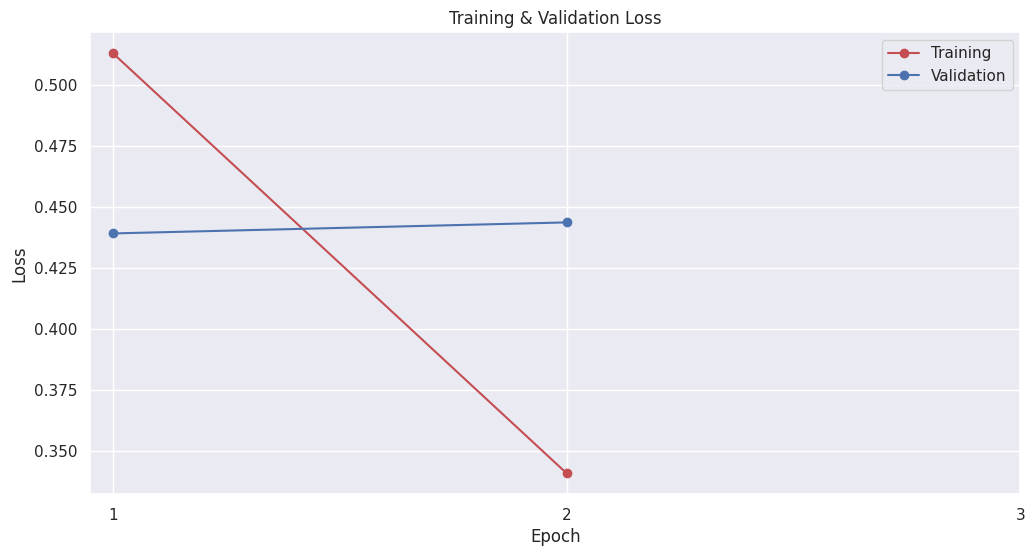

In [28]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(stats_df['Training Loss'], 'r-o', label="Training")
plt.plot(stats_df['Validation Loss'], 'b-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

Model Testing

In [29]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['source', 'label', 'label_notes', 'sentence'])

# Print number of sentences
print('Number of testing sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of testing sentences: 516



,source,label,label_notes,sentence
344,swb04,1,NaN,"Chris walks, Pat eats broccoli, and Sandy play..."
307,swb04,1,NaN,The guests dined.
327,swb04,1,NaN,A chair was broken.
302,swb04,1,NaN,How many feature structures categories can lab...
219,swb04,0,*,We gave us to the cause.
142,j_71,1,NaN,"I like Bill's yellow shirt, but not Max's."
500,w_80,1,NaN,I gave it to Pete to take to the fair.
329,swb04,1,NaN,They preferred them arrested.
356,swb04,1,NaN,Protect yourself!
35,clc95,1,NaN,Which book did each author recommend?


In [30]:
# Get lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.astype(int).values

In [31]:
# Convert labels to tensors
labels = torch.Tensor(labels)

In [32]:
input_ids, attention_masks = preprocess_text(sentences, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [33]:
# Create TestLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)

test_loader = DataLoader(test_dataset,
                            sampler = RandomSampler(test_dataset),
                            batch_size = batch_size
                            )

In [34]:
pred_test_labels, true_test_labels, epoch_val_loss = model_eval_epoch(model, test_loader)

In [35]:
print(len(true_test_labels))

17


In [36]:
# Calculate batchwise Mathews Correlation Coefficient
mcc_batch = []
for p_batch, t_batch in zip(pred_test_labels, true_test_labels):
  # Get labels of batch
  pred_labels =  np.argmax(p_batch, axis=1).flatten()
  # Calculate MCC for the batch
  mcc = smetrics.matthews_corrcoef(t_batch, pred_labels)
  # Append MCC score to list
  mcc_batch.append(mcc)

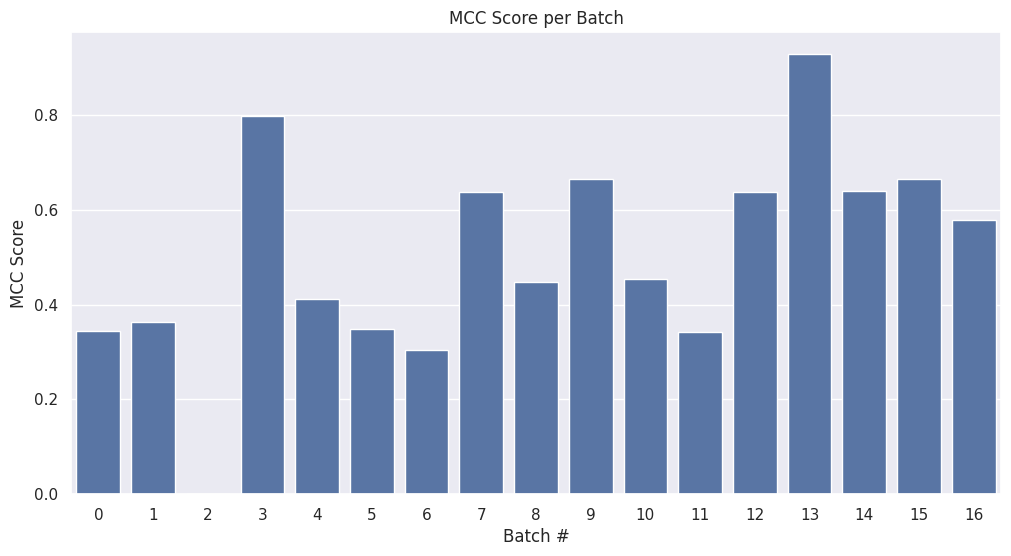

In [37]:
# Plot MCC vs batch
ax = sns.barplot(x=list(range(len(mcc_batch))), y=mcc_batch, errorbar=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score')
plt.xlabel('Batch #')

plt.show()

In [38]:
# Concatenate prediction across all batches
flat_pred_labels = np.concatenate(pred_test_labels, axis=0)

# Get labels
flat_pred_labels = np.argmax(flat_pred_labels, axis=1).flatten()

# Concatenate true labels across all batches
flat_true_labels = np.concatenate(true_test_labels, axis=0)

# Calculate the MCC
mcc = smetrics.matthews_corrcoef(flat_true_labels, flat_pred_labels)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.524


In [39]:
# Get accuracy
acc = smetrics.accuracy_score(flat_true_labels, flat_pred_labels)

print('Accuracy: %.3f' % acc)

Accuracy: 0.806


Save model

In [40]:
# Directory to save model files
output_dir = './model/'

# Create directory if it doesn't exist
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model...")

# Save model config and tokenizer
model_save = model.module if hasattr(model, 'module') else model
model_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model...


('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json')


Load model

In [ ]:
'''
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)
'''